In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [15]:
covid_cases = pd.read_csv('../data.csv')

S = covid_cases['S']
I = covid_cases['I']
D = covid_cases['D']
R = covid_cases['R']
susceptible = []
infected = []
dead = []
recovered = []
timesteps = []

d1 = covid_cases['S']
d2 = covid_cases['I']
d3 = covid_cases['D']
d4 = covid_cases['R']
d5 = covid_cases['t']

for item in range(0, len(d5)):
    if item % 1 == 0:
        susceptible.append(d1[item])
        infected.append(d2[item])
        dead.append(d3[item])
        recovered.append(d4[item])
        timesteps.append(d5[item])

In [9]:
len(timesteps)

369

In [7]:
S_data

array([], dtype=float64)

In [16]:
days = np.array(timesteps)
S_data = np.array(susceptible)
I_data = np.array(infected)
R_data = np.array(recovered)
D_data = np.array(dead)
N = S_data[0] + I_data[0] + R_data[0] + D_data[0]  # общее население

In [29]:
def sird_model(t, y, beta, gamma, delta):
    """Модель SIRD"""
    S, I, R, D = y
    dSdt = -beta * I * S/N
    dIdt = beta * I * S/N - gamma * I - delta * I
    dRdt = gamma * I
    dDdt = delta * I
    return [dSdt, dIdt, dRdt, dDdt]


def solve_sird(params, t_span, y0):
    """Решаем систему SIRD с заданными параметрами"""
    beta, gamma, delta = params
    solution = solve_ivp(
        fun=lambda t, y: sird_model(t, y, beta, gamma, delta),
        t_span=t_span,
        y0=y0,
        t_eval=days,
        method='RK45'
    )
    return solution.y


def objective_function(params):
    """Целевая функция для минимизации (сумма квадратов отклонений)"""
    # Решаем модель с текущими параметрами
    solution = solve_sird(
        params, [days[0], days[-1]], [S_data[0], I_data[0], R_data[0], D_data[0]])
    S_pred, I_pred, R_pred, D_pred = solution

    # Вычисляем ошибку (MSE)
    error_S = np.sum((S_pred - S_data) ** 2)
    error_I = np.sum((I_pred - I_data) ** 2)
    error_R = np.sum((R_pred - R_data) ** 2)
    error_D = np.sum((D_pred - D_data) ** 2)

    # Можно настроить веса для разных компонент
    total_error = error_S + error_I + error_R + error_D
    return total_error

Найденные параметры:
β (beta) = 0.1073
γ (gamma) = 0.0815
μ (mu) = 0.0184
R₀ = 1.07


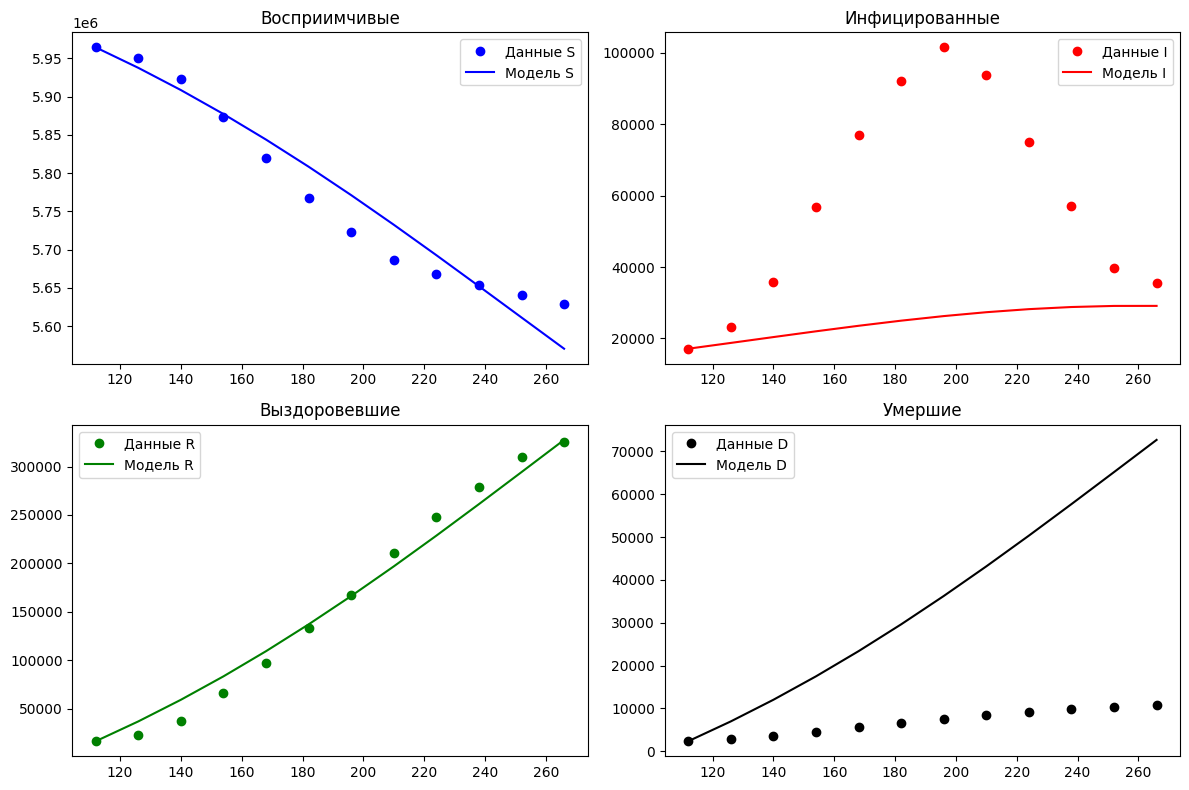

In [39]:
initial_guess = [0.5, 0.1, 0.01]  # [beta, gamma, delta]

# Ограничения параметров (положительные значения)
bounds = [(0.001, 2), (0.001, 1), (0.001, 0.20)]

# Минимизация целевой функции
result = minimize(
    objective_function,
    initial_guess,
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 1000, 'disp': True}
)

# Извлекаем найденные параметры
beta_opt, gamma_opt, mu_opt = result.x
R0 = beta_opt / (gamma_opt + mu_opt)

print(f"Найденные параметры:")
print(f"β (beta) = {beta_opt:.4f}")
print(f"γ (gamma) = {gamma_opt:.4f}")
print(f"μ (mu) = {mu_opt:.4f}")
print(f"R₀ = {R0:.2f}")

# Решаем модель с оптимальными параметрами для визуализации
solution_opt = solve_sird([beta_opt, gamma_opt, mu_opt],
                          [days[0], days[-1]],
                          [S_data[0], I_data[0], R_data[0], D_data[0]])

S_opt, I_opt, R_opt, D_opt = solution_opt

# Визуализация результатов
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(days, S_data, 'bo', label='Данные S')
plt.plot(days, S_opt, 'b-', label='Модель S')
plt.legend()
plt.title('Восприимчивые')

plt.subplot(2, 2, 2)
plt.plot(days, I_data, 'ro', label='Данные I')
plt.plot(days, I_opt, 'r-', label='Модель I')
plt.legend()
plt.title('Инфицированные')

plt.subplot(2, 2, 3)
plt.plot(days, R_data, 'go', label='Данные R')
plt.plot(days, R_opt, 'g-', label='Модель R')
plt.legend()
plt.title('Выздоровевшие')

plt.subplot(2, 2, 4)
plt.plot(days, D_data, 'ko', label='Данные D')
plt.plot(days, D_opt, 'k-', label='Модель D')
plt.legend()
plt.title('Умершие')

plt.tight_layout()
plt.show()

In [46]:
def f(x):
    pass


def diff(data, x_left, x_right, delta_x):
    return (data[x_right] - data[x_left]) / (2 * delta_x)


def beta_t(t):
    dSdt = diff(S_data, t-1, t+1, 1)
    return - dSdt*N/I_data[t]/S_data[t]


def gamma_t(t):
    dRdt = diff(R_data, t-1, t+1, 1)
    return dRdt/I_data[t]


def delta_t(t):
    dDdt = diff(D_data, t-1, t+1, 1)
    return dDdt/I_data[t]

In [17]:
class EpidParams:
    def __init__(self, S, I, R, D, timesteps):
        self.S_data = S
        self.I_data = I
        self.R_data = R
        self.D_data = D
        self.timesteps = timesteps
        self.N = S[0] + I[0] + R[0] + D[0]

    def _diff(self, data, x_left, x_right, delta_x):
        # print(data[x_right])
        # print(data[x_left])
        return (data[x_right] - data[x_left]) / (2 * delta_x)

    def beta_t(self, t):
        dSdt = self._diff(self.S_data, t-1, t+1, 1)
        # print(dSdt)
        return - dSdt*self.N/self.I_data[t]/self.S_data[t]

    def gamma_t(self, t):
        dRdt = self._diff(self.R_data, t-1, t+1, 1)
        return dRdt/self.I_data[t]

    def delta_t(self, t):
        dDdt = self._diff(self.D_data, t-1, t+1, 1)
        return dDdt/self.I_data[t]

    def Rt(self, t):
        # return self.beta_t(t)/(self.gamma_t(t) + self.delta_t(t))*(self.N/self.S_data[t])
        # return self.I_data[t]/(self.R_data[t]+self.D_data[t])
        print(self.I_data[t-4:t])
        return np.sum(self.I_data[t-4:t])/np.sum(self.I_data[t-8:t-4])

    def R0(self):
        return self.Rt(1)

    def Rt_array(self):
        Rt_array = np.zeros(len(self.timesteps)-2)
        for i in range(8, len(self.timesteps)-1):
            print(i)
            Rt_array[i-1] = self.Rt(i)

        return Rt_array

In [5]:
S_data = np.array([5391131.5000, 5390542.0000, 5389966.0000, 5389396.5000, 5388836.5000,
                   5388286.0000, 5387741.0000, 5387206.0000, 5386680.0000])
I_data = np.array([7272.8315, 6689.3013, 6111.1895, 5535.6665, 4965.7930, 4400.7261,
                   3837.3159, 3279.8965, 2724.5359])
R_data = np.array([320797.0000, 320845.0000, 320887.1875, 320923.7188, 320957.3125,
                   320986.0938, 321009.7188, 321030.3125, 321042.9062])
D_data = np.array([14890.4551, 14909.6230, 14928.4551, 14947.1855, 14965.6602, 14983.9209,
                   15002.0605, 15019.9531, 15037.6885])
timesteps = np.array([np.float64(360.0), np.float64(361.0), np.float64(362.0), np.float64(
    363.0), np.float64(364.0), np.float64(365.0), np.float64(366.0), np.float64(367.0), np.float64(368.0)])

In [16]:
epidParams.N

np.float64(5734091.7866)

In [18]:
epidParams = EpidParams(S_data, I_data, R_data, D_data, timesteps)
epidParams.Rt_array()

8
[4427 4550 4623 4734]
9
[4550 4623 4734 4850]
10
[4623 4734 4850 4906]
11
[4734 4850 4906 4984]
12
[4850 4906 4984 5069]
13
[4906 4984 5069 5127]
14
[4984 5069 5127 5177]
15
[5069 5127 5177 5252]
16
[5127 5177 5252 5309]
17
[5177 5252 5309 5378]
18
[5252 5309 5378 5441]
19
[5309 5378 5441 5505]
20
[5378 5441 5505 5566]
21
[5441 5505 5566 5635]
22
[5505 5566 5635 5722]
23
[5566 5635 5722 5809]
24
[5635 5722 5809 5873]
25
[5722 5809 5873 5940]
26
[5809 5873 5940 5987]
27
[5873 5940 5987 6048]
28
[5940 5987 6048 6104]
29
[5987 6048 6104 6177]
30
[6048 6104 6177 6256]
31
[6104 6177 6256 6307]
32
[6177 6256 6307 6408]
33
[6256 6307 6408 6467]
34
[6307 6408 6467 6513]
35
[6408 6467 6513 6575]
36
[6467 6513 6575 6699]
37
[6513 6575 6699 6804]
38
[6575 6699 6804 6863]
39
[6699 6804 6863 6919]
40
[6804 6863 6919 6968]
41
[6863 6919 6968 7033]
42
[6919 6968 7033 7099]
43
[6968 7033 7099 7199]
44
[7033 7099 7199 7287]
45
[7099 7199 7287 7342]
46
[7199 7287 7342 7401]
47
[7287 7342 7401 7463]
48

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.07210105, 1.08228031, 1.08424098,
       1.08472122, 1.08045162, 1.07085355, 1.06508659, 1.05910445,
       1.0533091 , 1.0512795 , 1.05025298, 1.04887273, 1.04912533,
       1.04882554, 1.04901777, 1.05080202, 1.05248972, 1.05404795,
       1.05265739, 1.04909379, 1.04514085, 1.04163811, 1.04134017,
       1.04176451, 1.04439553, 1.04614246, 1.04514948, 1.04504106,
       1.04397964, 1.04532589, 1.04849192, 1.05091861, 1.04951626,
       1.0448272 , 1.04001336, 1.03716328, 1.03861508, 1.04117626,
       1.04318498, 1.0421923 , 1.03931092, 1.03685138, 1.03633378,
       1.03902621, 1.0421948 , 1.04641083, 1.04872734, 1.04829657,
       1.04797084, 1.04734746, 1.04658923, 1.04628938, 1.045344  ,
       1.04192145, 1.03828917, 1.03510755, 1.03383591, 1.03643902,
       1.03945539, 1.04256848, 1.04372347, 1.04163732, 1.03996433,
       1.03810101, 1.03717046, 1.03680865, 1.0362847 , 1.03579

In [ ]:
epidParams = EpidParams(S_data, I_data, R_data, D_data, timesteps)

epidParams.delta_t(1)

14928.4551
14890.4551


np.float64(0.0028403564360301725)

In [21]:
epidParams.beta_t(1)

5389966.0
5391131.5
-582.75


np.float64(0.09266884083565108)

In [22]:
epidParams.gamma_t(1)

320887.1875
320797.0


np.float64(0.00674117489669661)

C:\Users\dinar\AppData\Local\Temp\ipykernel_13072\1596723020.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Rt_array[i-1] = self.Rt(i)


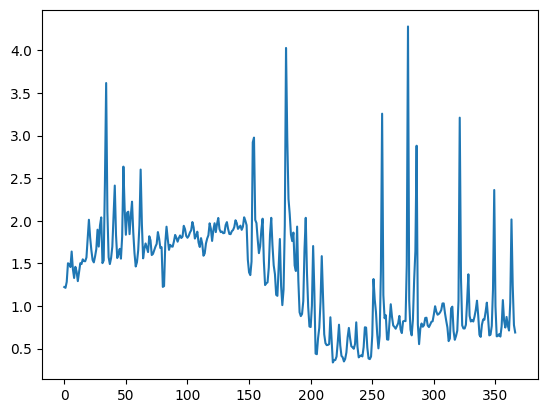

In [56]:
plt.plot(epidParams.Rt_array())

In [ ]:
def Ro():
    return beta_t(0)/(gamma_t(0) + delta_t(0))*(N/S_data[0])

In [47]:
for i in range(1, len(timesteps)-1):
    print("_______________________________")
    print(beta_t(i))
    print(gamma_t(i))
    print(delta_t(i))
    print(f'Rt = {beta_t(i)/(gamma_t(i) + delta_t(i))*(N/S_data[i])}')

_______________________________
0.06565291364995837
0.04291088643310604
0.010815894662591112
Rt = 1.2229490586431664
_______________________________
0.06671500732344297
0.043973941368078175
0.011051651931130758
Rt = 1.213456261518292
_______________________________
0.06748482602537163
0.043073742246726394
0.009533654950608775
Rt = 1.2839437915834295
_______________________________
0.06692525556415731
0.03817483623221143
0.006437768240343348
Rt = 1.5015517673899155
_______________________________
0.06555932181066898
0.03703296703296703
0.006923076923076923
Rt = 1.4929506016875878
_______________________________
0.06376941566882223
0.03709712308025092
0.006705602422669262
Rt = 1.4573448653873842
_______________________________
0.06174856371376388
0.03316434305027461
0.004541613857203211
Rt = 1.6394159490488498
_______________________________
0.05903609781466738
0.035670103092783505
0.00556701030927835
Rt = 1.4332525914478411
_______________________________
0.0556099718082061
0.0367916836